### COMP0082 Coursework V2.02
##### Predicting the subcellular location of proteins

**Goal** : develop a simple method for classifying eukaryotic protein sequences into the 5 categories
* Cytosolic - i.e. within the cell itself, but not inside any organelles

* Extracellular/Secreted - proteins which are transported out of a cell

* Nuclear - proteins found/used within the cell's nucleus

* Mitochondrial - proteins transported to the cell's mitochondria

* Other - none of the above

**Requirements** :
* use any appropriate ML methods, free to use off-the-shelf machine learning methods or libraries, as long as you give enough information for someone to replicate your approach
* Methods should be self-contained
* No requests to external web services
* **extra credit** will be given to being able to make the results from your method **explainable**, e.g. use ablaton test or integrated gradients for methods without explicit features
* Predictions must be returned along with some measure of confidence or converted in ad hoc measure of confidence e.g. HIGH, MEDIUM, LOW
* Must explain the basis of your confidence
* Cross-validation studies should be carried out on the datasets.
* Details on the selection of test and training sets must be given in the write-up
* Appropriate measures of success must be given e.g. ACC, F1, MCC etc.
* Results for the "blind" protein set must be included in the report.


In [ ]:
!pip install biopython


[notice] A new release of pip is available: 23.1.2 -> 25.0.1
[notice] To update, run: C:\Users\Marco\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [1]:
# Load the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from Bio import SeqIO

#### Load the FASTA files

SeqIO.parse from Biopython is an efficient way to read and process FASTA files when preparing data for training a machine learning model for the classification of subcellular localization of proteins. The SeqIO.parse function returns SeqRecord objects, which include attributes such as id, name, description, and seq. These attributes help organize and access the sequence data and metadata in a structured manner.

In [2]:
# Load the data
from Bio import SeqIO
import os

def load_fasta_file_assign_class(fasta_file_path, print_data=False):

    label = os.path.splitext(os.path.basename(fasta_file_path))[0]  # Get filename without extension

    # Parse the FASTA file
    records = SeqIO.parse(fasta_file_path, "fasta")
    sequences = []

    for record in records:
    # You can store the sequence and the label together in a tuple or dictionary
        sequences.append((record.seq, label))  # Here, we're storing the sequence and the label as a tuple

        if print_data:
            print("Printing the record:")
            print(record)
            print("Printing the sequence:")
            print(record.seq)
            print("Printing the label:")
            print(label)

    # Assign a label to each sequence based on the file it came from
    # records = [(record.id, record.seq) for record in SeqIO.parse(fasta_file_path, "fasta")]

    return sequences

In [3]:
cyto_records = load_fasta_file_assign_class ("data/cyto.fasta")

In [4]:
print(cyto_records)

[(Seq('MGEGALAPGLQLLLRACEQGDTDTARRLLEPGGEPVAGSEAGAEPAGPEAARAV...SRR'), 'cyto'), (Seq('MLVKPMACYFEIWTRKVTTIEDFSLAIANRFKQMGSHSDSEVDWDNEEEVWEDE...VLN'), 'cyto'), (Seq('MPPKQHRHQKKDKNDNALQNTIGFVPPGATLASVSGYRPPDAFVNRIDRNIPVP...KTT'), 'cyto'), (Seq('MATSANLDIGAQLIVEECPSSYISGMPDIKLEHQLDPNPDEGAAQGVAMGMKFI...IRE'), 'cyto'), (Seq('MEQIQMVKVLEKCQVTPPSDTTDVELSLPVTFFDIPWLHLNKMQSLLFYDFPYP...SLS'), 'cyto'), (Seq('LVVLLQGTREEDDVVREQLVEGAGTDEKALIEILATRXNA'), 'cyto'), (Seq('MTWKNFGFEIFGEKYGQEELEKRIKDEHTPPPDSPVFGGLKLKLKKEKFKTLFT...TAI'), 'cyto'), (Seq('MPCPAQISDDLEFFVNGRKVTEKNVDPEVTLLAFLRKNLCLTGTKDACGTGGCG...PIA'), 'cyto'), (Seq('MSSLYTKLVKGATKIKMAPPKQKYVDPILSGTSSARGLQEITHALDIRLSDTAW...IDI'), 'cyto'), (Seq('MAGIRLHVIAPLALAAVSKCARDPAVYVRRCAANALPKLHDLRLEEHASAIEEL...SAT'), 'cyto'), (Seq('MALKMVKGSIDRMFDKNLQDLVRGIRNHKEDEAKYISQCIDEIKQELKQDNIAV...ATC'), 'cyto'), (Seq('MSTIEAIYLVDTNGALLLQLESRGRTSPITLEHIKNELFRYKLRNEEPPFILHN...RFR'), 'cyto'), (Seq('MAAAPPLRDRLSFLHRLPILLKGTSDDDVPCPGYLFEEIAKISHESPGSSQCLL...LNA'), '

In [5]:
secreted_records = load_fasta_file_assign_class("data/secreted.fasta")

In [6]:
mito_records = load_fasta_file_assign_class("data/mito.fasta")

In [7]:
nucleus_records = load_fasta_file_assign_class("data/nucleus.fasta")

In [8]:
other_records = load_fasta_file_assign_class("data/other.fasta")

---

#### 1. Compute Summary Statistics

* ⬜ Sequence Length (min, max, average)
* ⬜ Base Composition (A, T, G, C, and GC/AT content)
* ⬜ K-mer Distribution
* ⬜ Motif Analysis
* ⬜ GC Skew
* ⬜ Entropy
* ⬜ Pairwise Sequence Similarity
* ⬜ Diversity Metrics (e.g., Shannon entropy, nucleotide diversity)

In [9]:
from collections import Counter

# Distribution of label classes
def class_counter(records):
    # Extract labels from the records
    labels = [label for _, label in records]

    # Compute the label distribution
    label_counter = Counter(labels)

    return label_counter

# The separation of classes is given by the separation of fasta files

cyto_class_numbers = class_counter(cyto_records)
secreted_class_numbers = class_counter(secreted_records)
mito_class_numbers = class_counter(mito_records)
nucleus_class_numbers = class_counter(nucleus_records)
other_class_numbers = class_counter(other_records)

In [18]:
print("Number of cyto classes: ", cyto_class_numbers)
sum(cyto_class_numbers.values())

Number of cyto classes:  Counter({'cyto': 2463})


2463

In [13]:
print("Number of secreted classes: ", secreted_class_numbers)

Number of secreted classes:  Counter({'secreted': 1236})


In [14]:
print("Number of mito classes: ", mito_class_numbers)

Number of mito classes:  Counter({'mito': 1023})


In [15]:
print("Number of nucleus classes: ", nucleus_class_numbers)

Number of nucleus classes:  Counter({'nucleus': 2736})


In [16]:
print("Number of other classes: ", other_class_numbers)

Number of other classes:  Counter({'other': 2002})


Plot the class distribution

In [10]:
import matplotlib.pyplot as plt

# Combine the class counts into a single dictionary
class_counts = {
    'cyto': sum(cyto_class_numbers.values()),
    'secreted': sum(secreted_class_numbers.values()),
    'mito': sum(mito_class_numbers.values()),
    'nucleus': sum(nucleus_class_numbers.values()),
    'other': sum(other_class_numbers.values())
}

# Extract labels and their counts
labels, counts = zip(*class_counts.items())

print("Labels: ", labels)
print("Counts: ", counts)

Labels:  ('cyto', 'secreted', 'mito', 'nucleus', 'other')
Counts:  (2463, 1236, 1023, 2736, 2002)


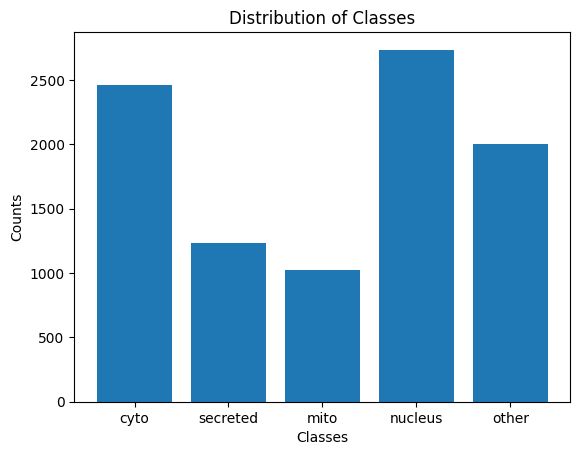

In [11]:
# Create a bar chart
plt.bar(labels, counts)
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.title('Distribution of Classes')
plt.show()

In [ ]:
# TODO: Choose if handle class imbalance
# best to handle class imbalance early in the preprocessing phase, 
# but it’s not always necessary. 
# If the imbalance is minor or the model and evaluation strategy are robust enough, 
# the issue may not need intervention. 
# Always consider the nature of the problem, the chosen model, 
# and the evaluation metrics when deciding whether to address class imbalance.

# TODO: Test with Cross-validation framework
# Cross-validation with/without adjustments: 
# - Compare model performance (e.g., accuracy, F1 score) with and without adjustments for imbalance 
# (such as resampling, class weighting, etc.). 
# If performance improves significantly with imbalance handling, 
# the imbalance might be a major issue.

### Experimentation and Model Selection:
To get started, I recommend testing multiple models, like Logistic Regression with Class Weights, Random Forest, and XGBoost, with your data. You can perform cross-validation and compare the performance based on F1 score, MCC, and confusion matrix.

If you find that one model outperforms the others, you can proceed with it and fine-tune it for the blind challenge set. Be sure to also test class balancing strategies and experiment with different feature sets to see how they impact your results.

Recommended Approach:
Start with simpler models (Logistic Regression and Random Forest) as baselines.

Incorporate class weights or resampling techniques if the imbalance is significant.

Experiment with more advanced models (like XGBoost or Neural Networks) if needed, but focus on explainability.

Always evaluate using F1 scores, Precision, Recall, and MCC to ensure you are handling the imbalance well.

In [ ]:
def sequence_length_at_gc_content(records):
    # Initialize the variables
    seq_lengths = []
    gc_contents = []
    at_contents = []

    # xxx
    amino_acid_compositions = []
    hydrophobicities = []

    # Loop through the records
    for record in records:
        # Get the sequence
        seq = record.seq

        # Calculate the sequence length
        seq_length = len(seq)
        seq_lengths.append(seq_length)

        # Calculate the GC content
        gc_content = (seq.count("G") + seq.count("C")) / seq_length
        gc_contents.append(gc_content)

        # Calculate the AT content
        at_content = (seq.count("A") + seq.count("T")) / seq_length
        at_contents.append(at_content)

    return seq_lengths, gc_contents, at_contents

# Frequency of each amino acid
def amino_acid_frequencies(records):
    # Define the amino acids
    amino_acids = "ACDEFGHIKLMNPQRSTVWY"

    # Initialize the list to store the results
    amino_acid_freqs = []

    # Loop through the records
    for record in records:
        # Get the sequence
        seq = record.seq

        # Calculate the sequence length
        seq_length = len(seq)

        # Calculate the frequency of each amino acid
        aa_freq = {aa: seq.count(aa) / seq_length for aa in amino_acids}
        amino_acid_freqs.append(aa_freq)

    return amino_acid_freqs


# Calculate the required statistics
#min_length = min(sequence_lengths)
#max_length = max(sequence_lengths)
#avg_length = np.mean(sequence_lengths)
#std_dev_length = np.std(sequence_lengths)

# Print the results
#print(f"Length of each sequence: {sequence_lengths}")
#print(f"Minimum sequence length: {min_length}")
#print(f"Maximum sequence length: {max_length}")
#print(f"Average sequence length: {avg_length:.2f}")
#print(f"Length variance: {np.var(sequence_lengths):.2f}")
#print(f"Length standard deviation: {std_dev_length:.2f}")

---

#### 2. Feature extraction

In [ ]:
# Sequence length feature
def sequence_length(records):
    sequence_length = []
    for record in records:
        sequence_length.append(len(record.seq))
    return sequence_length

In [ ]:
# Compute the percentage of all 20 aminoacids present in the sequence
def amino_acid_composition(records):
    amino_acids = "ACDEFGHIKLMNPQRSTVWY"
    amino_acid_composition = []
    for record in records:
        sequence = record.seq
        sequence_length = len(sequence)
        aa_count = {}
        for aa in amino_acids:
            aa_count[aa] = sequence.count(aa)
        aa_percent = {k: v / sequence_length for k, v in aa_count.items()}
        amino_acid_composition.append(aa_percent)
    return amino_acid_composition

In [ ]:
#test
cyto_amino_acid_composition = amino_acid_composition(cyto_records)
print(cyto_amino_acid_composition)

[{'A': 0.09830508474576272, 'C': 0.010169491525423728, 'D': 0.0519774011299435, 'E': 0.05423728813559322, 'F': 0.01807909604519774, 'G': 0.09378531073446328, 'H': 0.0327683615819209, 'I': 0.01807909604519774, 'K': 0.04632768361581921, 'L': 0.1096045197740113, 'M': 0.022598870056497175, 'N': 0.03615819209039548, 'P': 0.08022598870056497, 'Q': 0.03615819209039548, 'R': 0.061016949152542375, 'S': 0.103954802259887, 'T': 0.0519774011299435, 'V': 0.0576271186440678, 'W': 0.010169491525423728, 'Y': 0.006779661016949152}, {'A': 0.053406998158379376, 'C': 0.02394106813996317, 'D': 0.0865561694290976, 'E': 0.06445672191528545, 'F': 0.058931860036832415, 'G': 0.04604051565377532, 'H': 0.01841620626151013, 'I': 0.06077348066298342, 'K': 0.06813996316758748, 'L': 0.08103130755064457, 'M': 0.02578268876611418, 'N': 0.053406998158379376, 'P': 0.03314917127071823, 'Q': 0.03683241252302026, 'R': 0.03130755064456722, 'S': 0.07366482504604052, 'T': 0.06445672191528545, 'V': 0.0718232044198895, 'W': 0.01

**List of possible features** - Compute it for each FASTA File
- (done) Sequence length
- Global amino acid composition (i.e. percentages of all 20 amino acids present in whole sequence)
- Local amino acid composition (i.e. over first 50 amino acids or last 50 amino acids)
- Isoelectric point & molecular weight (e.g. see HERE or HERE)
- Specific sequence patterns near the start or near the end of the sequence
- Amino Acid Physicochemical Properties (Hydrophobicity, Hydrophilicity, Charge Distribution)
- Secondary Structure Prediction
- Protein Motifs (e.g., Nuclear Localization Signals, Signal Peptides)
- Protein Domains (e.g., Transmembrane, DNA-Binding Domains)
- Post-Translational Modifications (e.g., Phosphorylation Sites, Glycosylation Sites)
- Codon Usage Bias
- Subcellular Localization Signals (e.g., Signal Peptides, NLS)
- Structural Features (e.g., Transmembrane Helices, Disordered Regions)
- Evolutionary Conservation
- Homology-Based Features (e.g., BLAST Hits, Homologous Sequences)
- Protein-Protein Interaction Networks
- Predicted Subcellular Localization (e.g., DeepLoc, WoLF PSORT)
- Amino Acid Composition-Based Indices (e.g., Amino Acid Distribution Across Sequence)

In [ ]:
# Function to extract all features for a given sequence
def extract_all_features(sequence):
    features = {}


---

XXX - Comparing the raw file with the ingested one. See if there are potential issues before to feed it into the model, otherwise you will do some refinements later.